<a href="https://colab.research.google.com/github/yuvalira/COVID-19-Detection-from-Chest-X-Ray/blob/main/notebooks/covid19_xray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and Its Applications to Signal and Image Processing and Analysis



# Data Loading & Classification - COVID-19

**Deep Learning and Its Applications to Signal and Image Processing and Analysis, 361-2-1120**

In the following assignment we will create a dataset and costum model for classification of pneumonia and COVID-19 cases.

**We will deal with imbalnced data, train a classification CNN model for 3 class classification (Normal,Bacterial, Covid-19), expirament with Transfer Learning and t-SNE**

# Import Libraries

In [ ]:
from google.colab import drive # If working with google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import random

# 1. Load and Explore the Data


## 1.1 Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing

The first dataset contains the covid 19 part of the data

The second dataset contians more then needed for this exercise, we will only use the healthy expamples (appears as Normal in the dataset) and those of the Bacterial subcatagory of Pneumonia  

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources.

Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597


In [ ]:
#We can use "!" to run bash commands in google colab
#The following command will download the latest available data from the git repository
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


Set images and metadata files path and examine data

In [ ]:
covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")

Use pandas to convert the metadata CSV to a dataframe object.

In [ ]:
covid_metadata = pd.read_csv(covid_metadata_path)

A look at the metadata:

In [ ]:
covid_metadata.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
6,5,NaN,NaN,NaN,Pneumonia,NaN,NaN,Y,Y,Y,...,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
9,3,4.0,M,74.0,Pneumonia/Viral/SARS,NaN,N,NaN,NaN,NaN,...,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN,NaN


In [ ]:
#List the images
list(covid_images_path.glob("*"))[0:10]

[PosixPath('covid-chestxray-dataset/images/000003-6.jpg'),
 PosixPath('covid-chestxray-dataset/images/000003-4.jpg'),
 PosixPath('covid-chestxray-dataset/images/08d780ae.jpg'),
 PosixPath('covid-chestxray-dataset/images/16745_6_1.png'),
 PosixPath('covid-chestxray-dataset/images/16745_7_1.png'),
 PosixPath('covid-chestxray-dataset/images/16664_1_1.jpg'),
 PosixPath('covid-chestxray-dataset/images/446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg'),
 PosixPath('covid-chestxray-dataset/images/16745_7_3.png'),
 PosixPath('covid-chestxray-dataset/images/000007-2.png'),
 PosixPath('covid-chestxray-dataset/images/16689_2_2.png')]

Visualize some cases

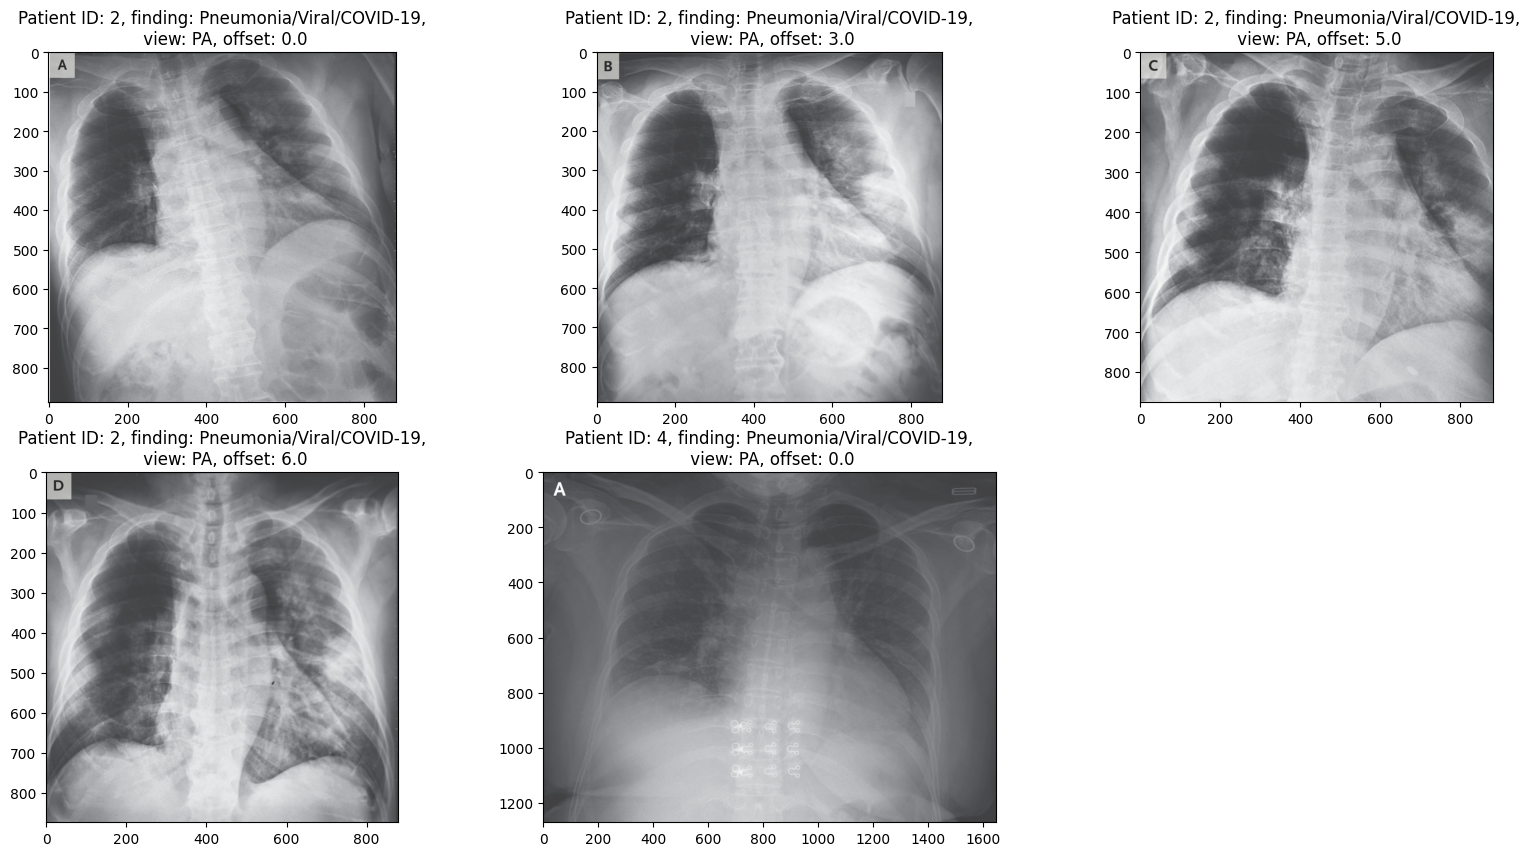

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
for index, case in covid_metadata.head(5).iterrows():
  plt.subplot(2,3,index+1)
  image_path = covid_images_path / case["filename"]
  # plt.figure()
  plt.title("Patient ID: {0}, finding: {1},\n view: {2}, offset: {3}".format(case["patientid"],case["finding"],case["view"],case["offset"]))
  plt.imshow(plt.imread(image_path),cmap='gray')
plt.show()

#### Filter Covid-19 Dataset
Filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views and return a dataframe that contains finding/full filepath as in the following figure:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [ ]:
filtered_metadata_PA = covid_metadata[covid_metadata["view"] == "PA"] # Filter only posteroanterior images
filtered_metadata_PA = filtered_metadata_PA[["finding", "filename"]]
filtered_metadata_PA["filepath"] = filtered_metadata_PA["filename"].apply(lambda x: os.path.join(covid_images_path, x)) # Adding filepaths
filtered_metadata_PA = filtered_metadata_PA[["finding", "filepath"]]
filtered_metadata_PA.head(10)

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
6,Pneumonia,covid-chestxray-dataset/images/ARDSSevere.png
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
12,Pneumonia/Viral/SARS,covid-chestxray-dataset/images/SARS-10.1148rg....


Filter the dataframe so it contains only COVID-19 cases:

In [ ]:
covid_cases = filtered_metadata_PA[filtered_metadata_PA["finding"] == "Pneumonia/Viral/COVID-19"]
covid_cases.head(10)

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
20,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/1-s2.0-S0140673...
21,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nCoV-radiol.202...


#### Train Test Split
split the data into train and test data.

In [ ]:
train_covid_data, test_covid_data = train_test_split(covid_cases, test_size=0.2, random_state=42)

### Load Pneumonia and Normal chest X-Ray

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
!pip install kaggle

##### Authenticating with Kaggle using kaggle.json

Upload kaggle.json to Colab runtime.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


##### Downloading Pneumonia and Normal chest X-Ray dataset

In [ ]:
!kaggle datasets download "tolgadincer/labeled-chest-xray-images"

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip labeled-chest-xray-images.zip

Archive:  labeled-chest-xray-images.zip
replace chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##### Create Train and Test DataFrames
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe and make sure it is of the same format of the covid 19 dataframe:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [ ]:
# Define Paths
dataset_path = Path("chest_xray")
train_path = dataset_path / "train"
test_path = dataset_path / "test"

# Create DataFrames
def create_dataframes(path):
    data = []

    # NORMAL images
    normal_path = os.path.join(path, "NORMAL")
    for fname in os.listdir(normal_path):
        if fname.endswith(".jpeg"):
            data.append({"finding": "NORMAL", "filepath": os.path.join(normal_path, fname)})

    # BACTERIA images (inside PNEUMONIA)
    pneumonia_path = os.path.join(path, "PNEUMONIA")
    for fname in os.listdir(pneumonia_path):
        if fname.endswith(".jpeg") and "bacteria" in fname.lower():
            data.append({"finding": "BACTERIA", "filepath": os.path.join(pneumonia_path, fname)})

    return pd.DataFrame(data)

# Create DataFrames
train_normal_bacteria_data = create_dataframes(train_path)
test_normal_bacteria_data = create_dataframes(test_path)

In [ ]:
# Check train dataframe
train_normal_bacteria_data.sample(10)

,finding,filepath
3452,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-960851-000...
3390,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-516591-000...
1494,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-9044474-00...
2365,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-213622-000...
909,NORMAL,chest_xray/train/NORMAL/NORMAL-3526928-0002.jpeg
3242,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-9545891-00...
257,NORMAL,chest_xray/train/NORMAL/NORMAL-6642991-0001.jpeg
1556,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-249675-000...
1604,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-830515-000...
1453,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-3099650-00...


In [ ]:
# Check test dataframe
test_normal_bacteria_data.sample(10)

,finding,filepath
278,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-9857270-000...
437,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-6168941-000...
67,NORMAL,chest_xray/test/NORMAL/NORMAL-630880-0001.jpeg
40,NORMAL,chest_xray/test/NORMAL/NORMAL-3983280-0001.jpeg
323,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-3961172-000...
383,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-3060399-000...
7,NORMAL,chest_xray/test/NORMAL/NORMAL-520267-0001.jpeg
239,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-227418-0003...
474,BACTERIA,chest_xray/test/PNEUMONIA/BACTERIA-2429208-000...
179,NORMAL,chest_xray/test/NORMAL/NORMAL-6195450-0001.jpeg


## Create a full dataset





concatenate the dataframes into one 2 dataframes: Test, Train

In [ ]:
# Combine training sets
train_temp_df = pd.concat([train_covid_data, train_normal_bacteria_data], ignore_index=True)

# Combine test sets
test_df = pd.concat([test_covid_data, test_normal_bacteria_data], ignore_index=True)

For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [ ]:
finding_to_label = {'NORMAL':0,
 'BACTERIA':1,
 'Pneumonia/Viral/COVID-19':2}
label_to_finding = {v: k for k, v in finding_to_label.items()}

# Convert findings from string to numeric classes, using dictionary
train_temp_df['label'] = train_temp_df['finding'].map(finding_to_label)
test_df['label'] = test_df['finding'].map(finding_to_label)

In [ ]:
# Check if converted correctly
train_temp_df.sample(5)

,finding,filepath,label
206,NORMAL,chest_xray/train/NORMAL/NORMAL-1070073-0001.jpeg,0
146,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/extubation-4.jpg,2
1877,BACTERIA,chest_xray/train/PNEUMONIA/BACTERIA-355597-000...,1
975,NORMAL,chest_xray/train/NORMAL/NORMAL-7061098-0001.jpeg,0
536,NORMAL,chest_xray/train/NORMAL/NORMAL-2031622-0001.jpeg,0


In [ ]:
# Split the train data into train and validation sets
train_df, val_df = train_test_split(train_temp_df, test_size=0.2, random_state=42, stratify=train_temp_df['label'])

## 1.2 Exlpore the data

### a. Show Data Statistics
Plot a histogram of the data and explain results

train counts label
0    1079
1    2030
2     125
Name: count, dtype: int64


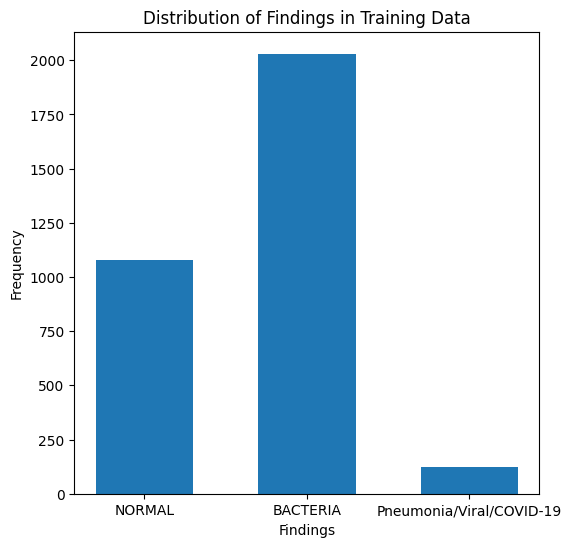

test counts label
0    234
1    242
2     40
Name: count, dtype: int64


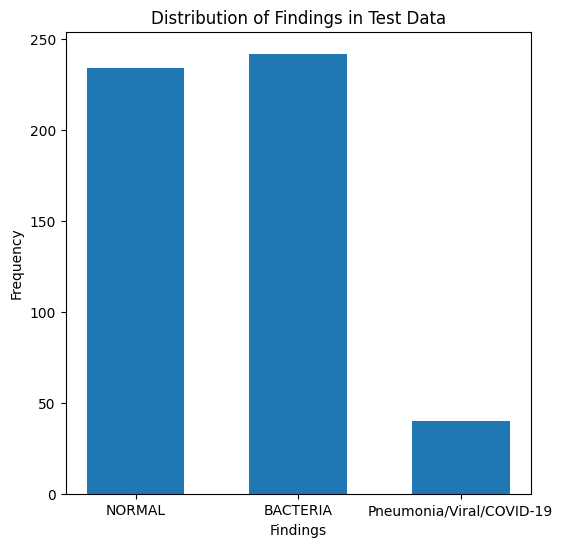

In [ ]:
# Count label frequencies
train_counts = train_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()
labels = [label_to_finding[i] for i in train_counts.index]

# Train data
print("train counts", train_counts)
plt.figure(figsize=(6, 6))
plt.bar(labels, train_counts.values, width=0.6)
plt.xlabel('Findings')
plt.ylabel('Frequency')
plt.title('Distribution of Findings in Training Data')
plt.show()

# Test data
print("test counts", test_counts)
plt.figure(figsize=(6, 6))
plt.bar(labels, test_counts.values, width=0.6)
plt.xlabel('Findings')
plt.ylabel('Frequency')
plt.title('Distribution of Findings in Test Data')
plt.show()

We can see that the distribution of the training and test data are class imbalance: in the training set, BACTERIA cases are the most prevalent (2030), followed by NORMAL (1079), and a very small number of COVID-19 cases (125). This imbalance may cause the model to favor the BACTERIA class during training, while underperforming on the underrepresented COVID-19 class due to limited exposure. The test set is more balanced between NORMAL and BACTERIA (around 240 each), but still contains very few COVID-19 samples (40), making it difficult to reliably evaluate model performance for that class.


### b. Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

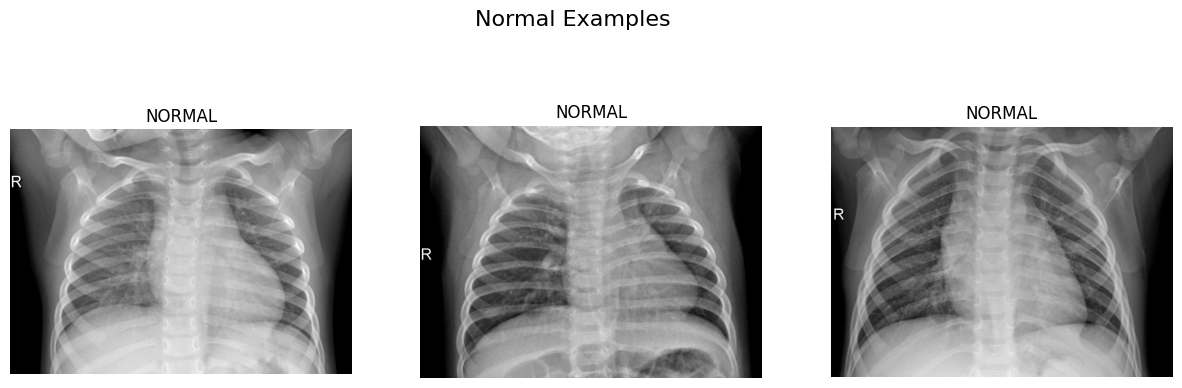

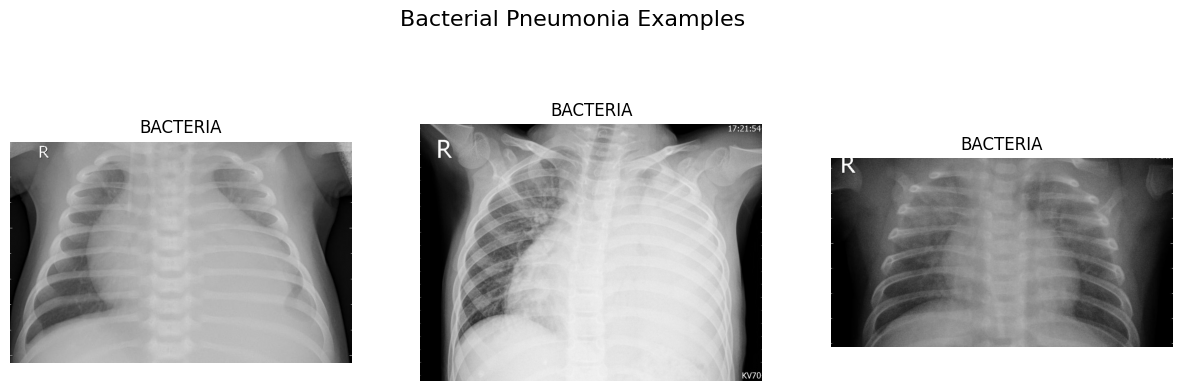

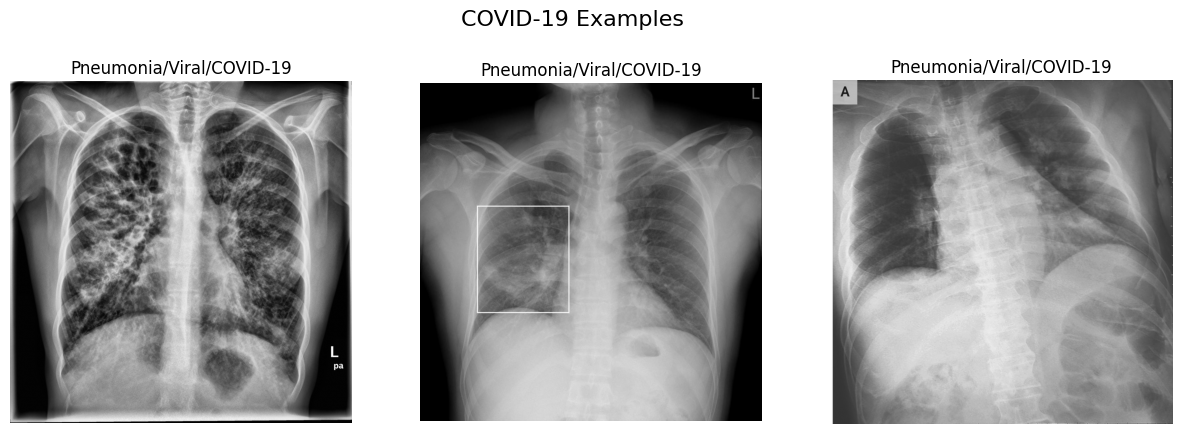

In [ ]:
# Function to display images from a dataframe
def show_images(df, title, num_images=3):
  plt.figure(figsize=(15, 5))
  plt.suptitle(title, fontsize=16)

  samples = df.sample(num_images)

  for i in range(num_images):
    image_path = samples.iloc[i]['filepath'] # Access the filepath
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(samples.iloc[i]['finding']) # Access the finding
    plt.axis('off')
  plt.show()

# Display images for each category
show_images(train_df[train_df['finding'] == 'NORMAL'], 'Normal Examples')
show_images(train_df[train_df['finding'] == 'BACTERIA'], 'Bacterial Pneumonia Examples')
show_images(train_df[train_df['finding'] == 'Pneumonia/Viral/COVID-19'], 'COVID-19 Examples')

**Biases and Corruptions:**

1.   Viewpoint Variation: this X-ray images are taken with different angles. This can introduce variations in the appearance of anatomical structures, potentially leading to bias if the model is trained on data with a skewed distribution of viewpoints.
2.   Image Quality: Differences in image resolution, contrast, and brightness can affect model performance. Low-quality images might contain noise or artifacts, hindering the model's ability to learn relevant features.
3. Patient Demographics: The dataset might be biased towards certain demographics (e.g., age, gender, ethnicity), which could lead to poor generalization to other populations.

**Avoiding Biases and Corruptions:**

1.   Data Augmentation: Apply transformations to the images during training (e.g., rotations, flips, brightness adjustments) to create variations in viewpoint and appearance. This can help the model learn more robust features and reduce bias.
2.   Image Preprocessing: Enhance image quality by applying techniques like contrast stretching, noise reduction, and artifact removal. This improves the clarity of images and makes it easier for the model to extract relevant information.

# 2. Dealing with imbalanced data







### a. Create a CNN model for classification

In [ ]:
class Classificaion_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(Classificaion_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

The model consists of the following layers:



1.   Input: The input to the model is a grayscale image of size 28x28.
2.   Convolutional Layer 1: Applies 32 filters of size 3x3 with padding of 1. Followed by a ReLU activation function.
3. Max Pooling Layer 1: Reduces the spatial dimensions by half using a 2x2 max pooling operation.
4. Convolutional Layer 2: Applies 64 filters of size 3x3 with padding of 1. Followed by a ReLU activation function.
5. Max Pooling Layer 2: Reduces the spatial dimensions by half using a 2x2 max pooling operation.
6. Flatten: Flattens the output from the previous layer into a single vector.
7. Fully Connected Layer 1: A linear layer with 128 output neurons. Followed by a ReLU activation function.
8. Fully Connected Layer 2: A linear layer with 3 output neurons (for the 3 classes: Normal, Bacteria, COVID-19)

### b. Create a baseline by training the network with the imbalanced data

Data preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 1]     # column 1 = filepath
        image = Image.open(image_path).convert('L')  # open image, convert to grayscale

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 2]         # column 2 = label (int)
        return image, label

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),                    # resize image to 28x28 pixels
    transforms.ToTensor(),                          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])     # Normalize pixel values to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=train_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)
val_dataset = CustomDataset(val_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Train function

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, device, criterion, lr=0.001, patience=3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}]  "
              f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_accuracy * 100:.2f}%  "
              f"| Val Loss: {val_loss:.4f}  Acc: {val_accuracy * 100:.2f}%")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # Restore Best Model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies, val_losses, val_accuracies

Evaluation function

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    model.to(device)
    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

    # Precision, Recall, F1 (macro = average across all classes equally)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1 Score (macro):  {f1:.4f}")

    return precision, recall, f1


Train and evaluate the model baseline

Epoch [1/8]  Train Loss: 0.3727  Acc: 82.99%  | Val Loss: 0.1620  Acc: 94.07%
Epoch [2/8]  Train Loss: 0.1552  Acc: 94.74%  | Val Loss: 0.1498  Acc: 95.67%
Epoch [3/8]  Train Loss: 0.1305  Acc: 95.30%  | Val Loss: 0.1113  Acc: 96.29%
Epoch [4/8]  Train Loss: 0.0987  Acc: 96.20%  | Val Loss: 0.1226  Acc: 95.80%
Epoch [5/8]  Train Loss: 0.0800  Acc: 97.25%  | Val Loss: 0.1220  Acc: 96.54%
Epoch [6/8]  Train Loss: 0.0829  Acc: 96.94%  | Val Loss: 0.1016  Acc: 96.42%
Epoch [7/8]  Train Loss: 0.0670  Acc: 97.62%  | Val Loss: 0.1025  Acc: 96.42%
Epoch [8/8]  Train Loss: 0.0517  Acc: 98.18%  | Val Loss: 0.1126  Acc: 96.04%


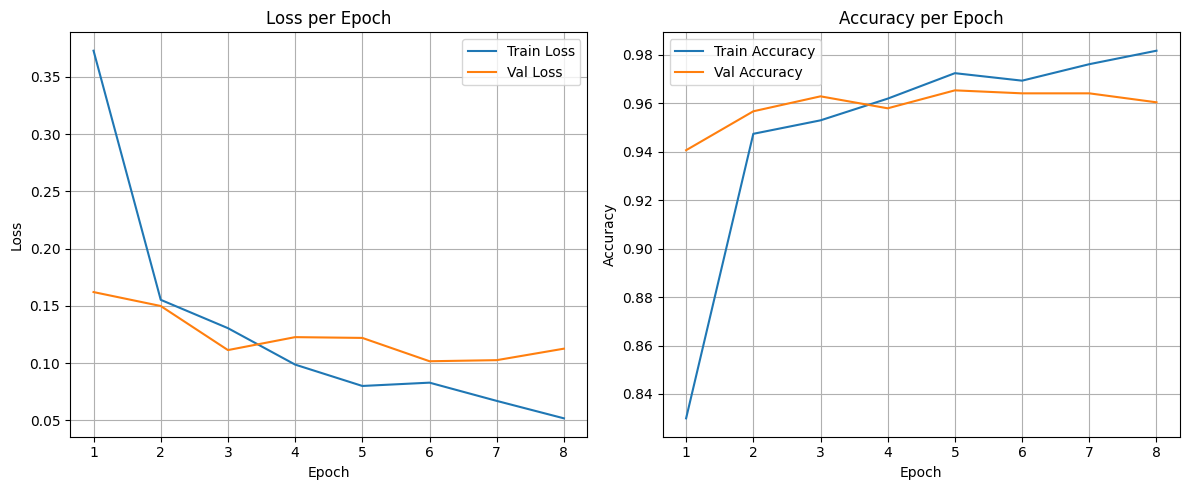

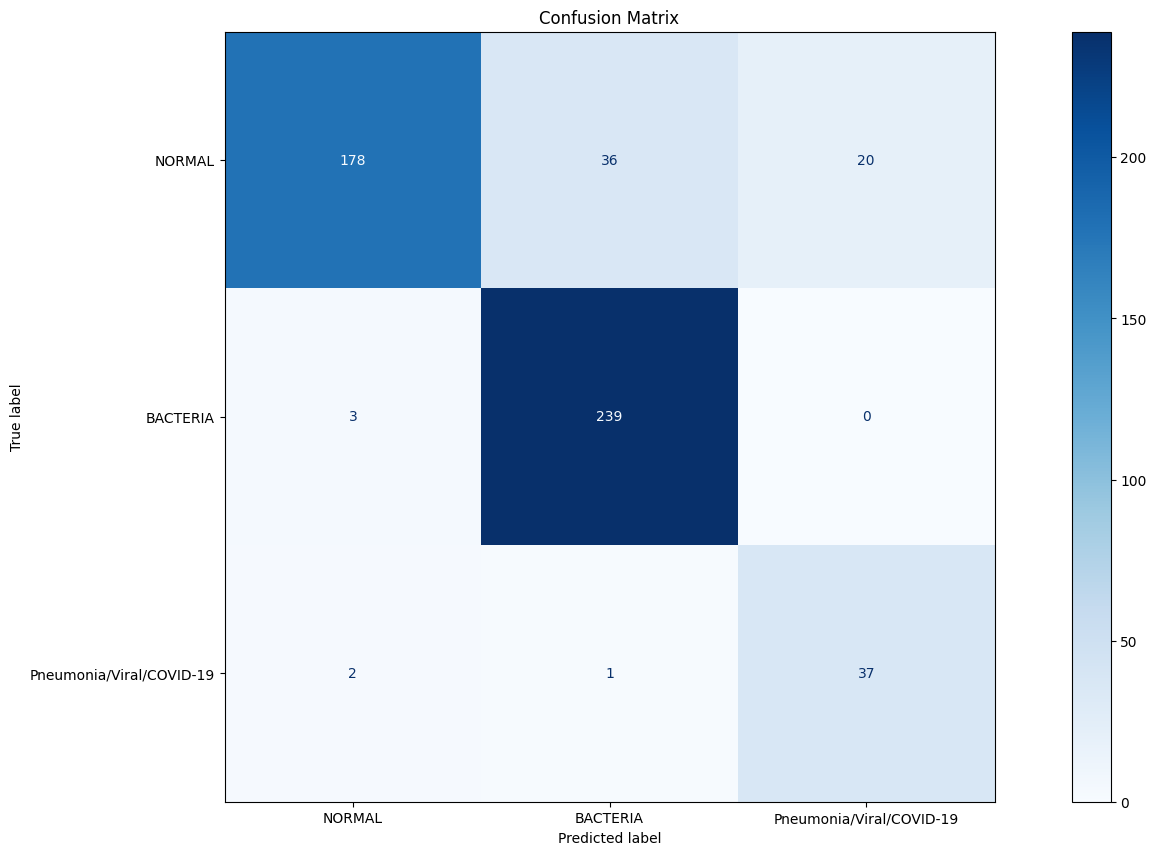

Precision (macro): 0.8292
Recall (macro):    0.8911
F1 Score (macro):  0.8465


(0.8292474772104889, 0.8910956888229616, 0.8464611823656547)

In [ ]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = Classificaion_CNN(num_classes=3)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=8, device=device, criterion=nn.CrossEntropyLoss())

# Evaluate the model
evaluate_model(model, test_loader, device, class_names=list(finding_to_label.keys()))

Evaluation

### c. Train the model using under-sampling

Epoch [1/8]  Train Loss: 0.7694  Acc: 61.60%  | Val Loss: 0.6123  Acc: 69.96%
Epoch [2/8]  Train Loss: 0.3868  Acc: 84.80%  | Val Loss: 0.5146  Acc: 84.18%
Epoch [3/8]  Train Loss: 0.3792  Acc: 84.27%  | Val Loss: 0.7330  Acc: 71.69%
Epoch [4/8]  Train Loss: 0.2559  Acc: 91.47%  | Val Loss: 0.4540  Acc: 81.71%
Epoch [5/8]  Train Loss: 0.1891  Acc: 92.53%  | Val Loss: 0.3899  Acc: 89.25%
Epoch [6/8]  Train Loss: 0.1507  Acc: 94.67%  | Val Loss: 0.2862  Acc: 92.95%
Epoch [7/8]  Train Loss: 0.1432  Acc: 94.67%  | Val Loss: 0.3919  Acc: 89.49%
Epoch [8/8]  Train Loss: 0.1278  Acc: 95.73%  | Val Loss: 0.2690  Acc: 93.08%


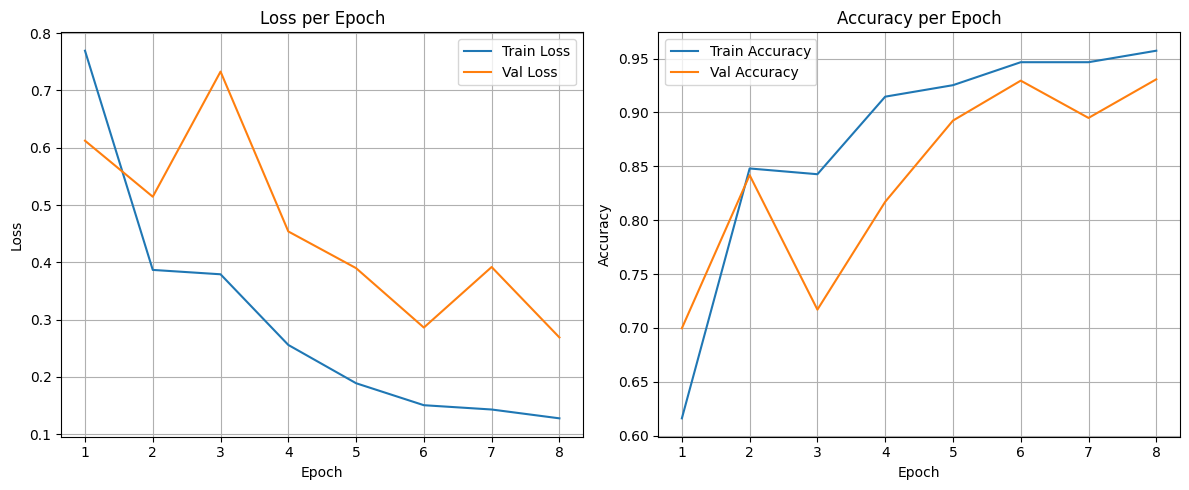

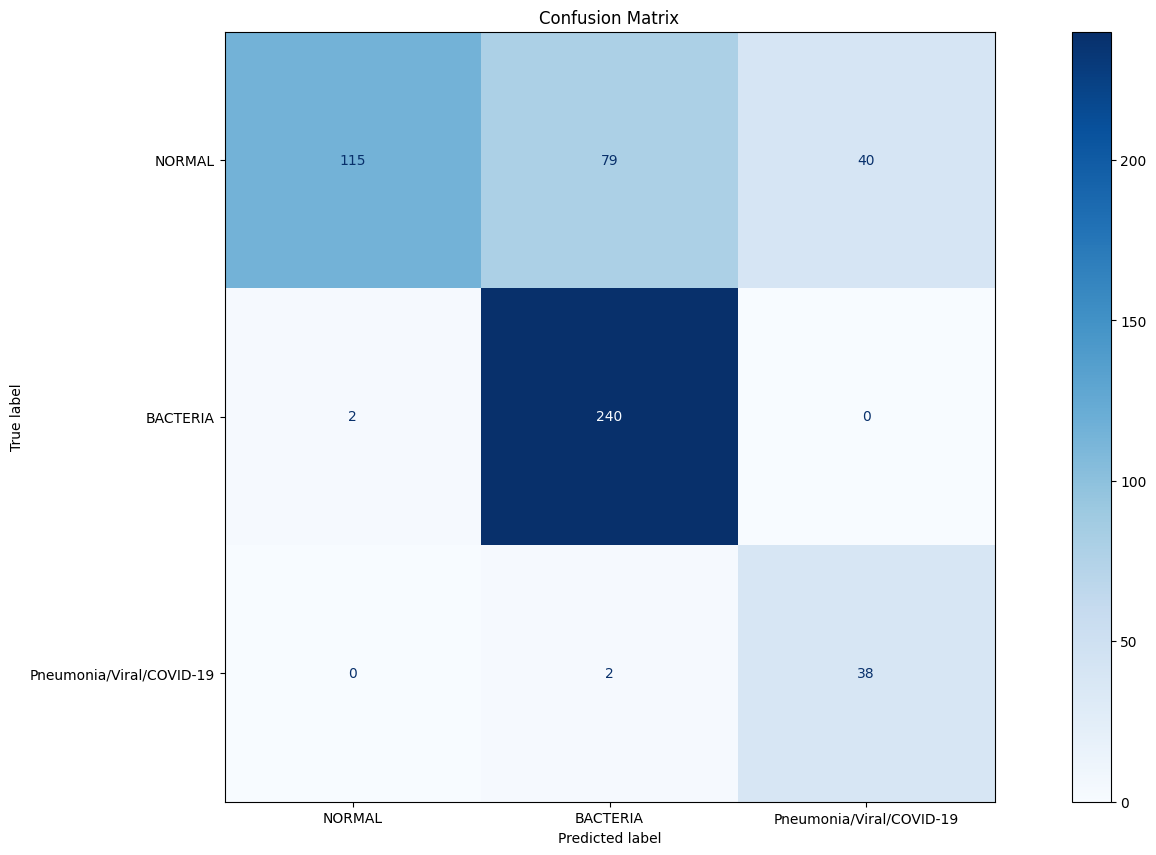

Precision (macro): 0.7392
Recall (macro):    0.8111
F1 Score (macro):  0.7173


(0.739249673829113, 0.8110628428810247, 0.7173046467785106)

In [ ]:
# Minority class
minority_class_size = len(train_df[train_df['finding'] == 'Pneumonia/Viral/COVID-19'])
covid_samples = train_df[train_df['finding'] == 'Pneumonia/Viral/COVID-19']

# Under-sample the majority classes
normal_undersampled = train_df[train_df['finding'] == 'NORMAL'].sample(minority_class_size, random_state=42)
bacteria_undersampled = train_df[train_df['finding'] == 'BACTERIA'].sample(minority_class_size, random_state=42)

# Create a balanced training dataset
balanced_train_df = pd.concat([normal_undersampled, bacteria_undersampled, covid_samples], ignore_index=True)

# Create train datasets and dataloaders
train_balanced_dataset = CustomDataset(balanced_train_df, transform=train_transform)
train_balanced_loader = DataLoader(train_balanced_dataset, batch_size=32, shuffle=True)

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model_undersampling = Classificaion_CNN(num_classes=3)

# Train the model
train_losses_balanced, train_accuracies_balanced, val_losses_balanced, val_accuracies_balanced = train_model(model_undersampling, train_balanced_loader, val_loader, num_epochs=8, device=device, criterion=nn.CrossEntropyLoss())

# Evaluate the model
evaluate_model(model_undersampling, test_loader, device, class_names=list(finding_to_label.keys()))

### d. Train the model using over-sampling

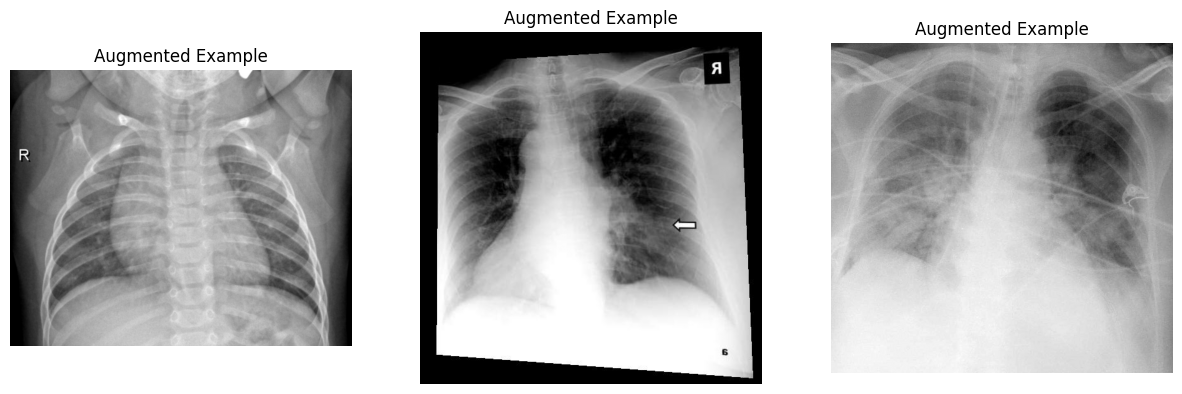

In [ ]:
# Function to augment images
def augment_image(image, label):
    if label == "NORMAL":
        # augmentations for NORMAL
        transforms_list = [
            transforms.RandomAffine(degrees=3, translate=(0.02, 0.02), scale=(0.98, 1.02)),
            transforms.GaussianBlur(kernel_size=3),
        ]
    elif label == "Pneumonia/Viral/COVID-19":
     # augmentations for COVID
      transforms_list = [
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.RandomRotation(degrees=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        ]

    if transforms_list:
        num_transforms = random.randint(1, len(transforms_list))
        selected_transforms = random.sample(transforms_list, num_transforms)

        augmented_image = image
        for transform in selected_transforms:
            augmented_image = transform(augmented_image)

    return augmented_image


# Separate classes
normal_samples = train_df[train_df['finding'] == 'NORMAL']
covid_samples = train_df[train_df['finding'] == 'Pneumonia/Viral/COVID-19']
bacteria_samples = train_df[train_df['finding'] == 'BACTERIA']

# Target class size
target_size = len(bacteria_samples)

oversampled_data = []

# Oversample NORMAL
oversample_factor_normal = int(target_size / len(normal_samples))

for index, row in normal_samples.iterrows():
    original_image = Image.open(row['filepath']).convert('L')
    for _ in range(oversample_factor_normal):
        augmented_image = augment_image(original_image, "NORMAL")
        temp_image_path = f"/tmp/aug_normal_{index}_{_}.jpeg"
        augmented_image.save(temp_image_path)
        oversampled_data.append({"finding": "NORMAL", "filepath": temp_image_path, "label": 0})

# Oversample COVID
oversample_factor_covid = int(target_size / len(covid_samples))

for index, row in covid_samples.iterrows():
    original_image = Image.open(row['filepath']).convert('L')
    for _ in range(oversample_factor_covid):
        augmented_image = augment_image(original_image, "Pneumonia/Viral/COVID-19")
        temp_image_path = f"/tmp/aug_covid_{index}_{_}.jpeg"
        augmented_image.save(temp_image_path)
        oversampled_data.append({"finding": "Pneumonia/Viral/COVID-19", "filepath": temp_image_path, "label": 2})

# Combine the original train set + oversampled data
oversampled_df = pd.DataFrame(oversampled_data)
train_oversampled_df = pd.concat([train_df, oversampled_df], ignore_index=True)

# Create new dataset and dataloader
train_oversampled_dataset = CustomDataset(train_oversampled_df, transform=train_transform)
train_oversampled_loader = DataLoader(train_oversampled_dataset, batch_size=32, shuffle=True)

# Show a few random augmented images
example_indices = random.sample(range(len(oversampled_df)), 3)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(example_indices):
    image_path = oversampled_df.iloc[idx]['filepath']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title('Augmented Example')
    plt.axis('off')
plt.show()

In [ ]:
# Count label frequencies in the oversampled training data
oversampled_train_counts = train_oversampled_df['label'].value_counts().sort_index()
oversampled_labels = [label_to_finding[i] for i in oversampled_train_counts.index]

oversampled_train_counts

,count
label,
0,2158
1,2030
2,2125


Epoch [1/8]  Train Loss: 0.2523  Acc: 89.67%  | Val Loss: 0.1379  Acc: 95.18%
Epoch [2/8]  Train Loss: 0.0928  Acc: 96.78%  | Val Loss: 0.1088  Acc: 96.42%
Epoch [3/8]  Train Loss: 0.0728  Acc: 97.51%  | Val Loss: 0.1002  Acc: 96.42%
Epoch [4/8]  Train Loss: 0.0526  Acc: 98.26%  | Val Loss: 0.1078  Acc: 96.42%
Epoch [5/8]  Train Loss: 0.0475  Acc: 98.43%  | Val Loss: 0.1126  Acc: 96.66%
Epoch [6/8]  Train Loss: 0.0346  Acc: 98.84%  | Val Loss: 0.1818  Acc: 95.18%
Early stopping triggered at epoch 6


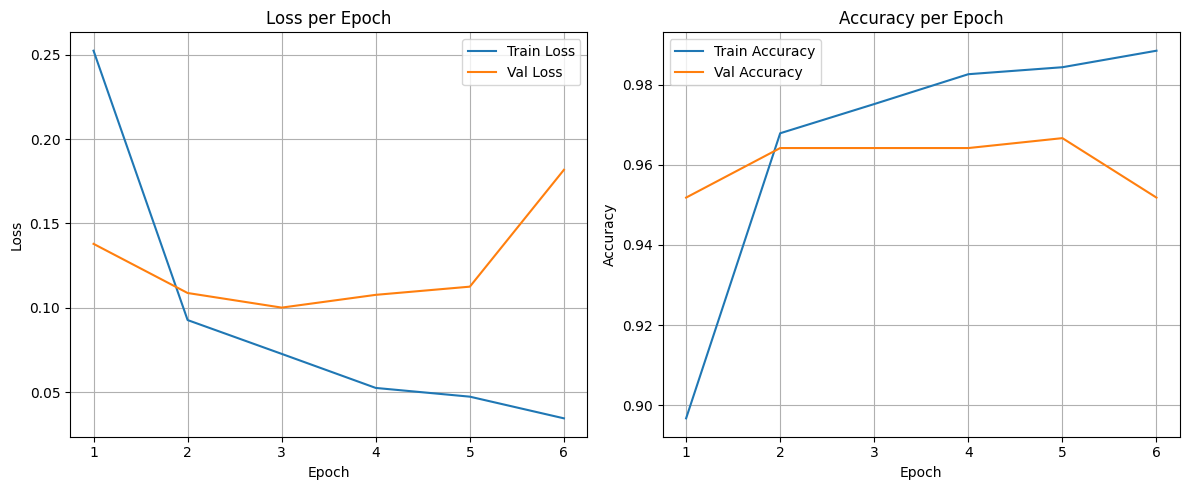

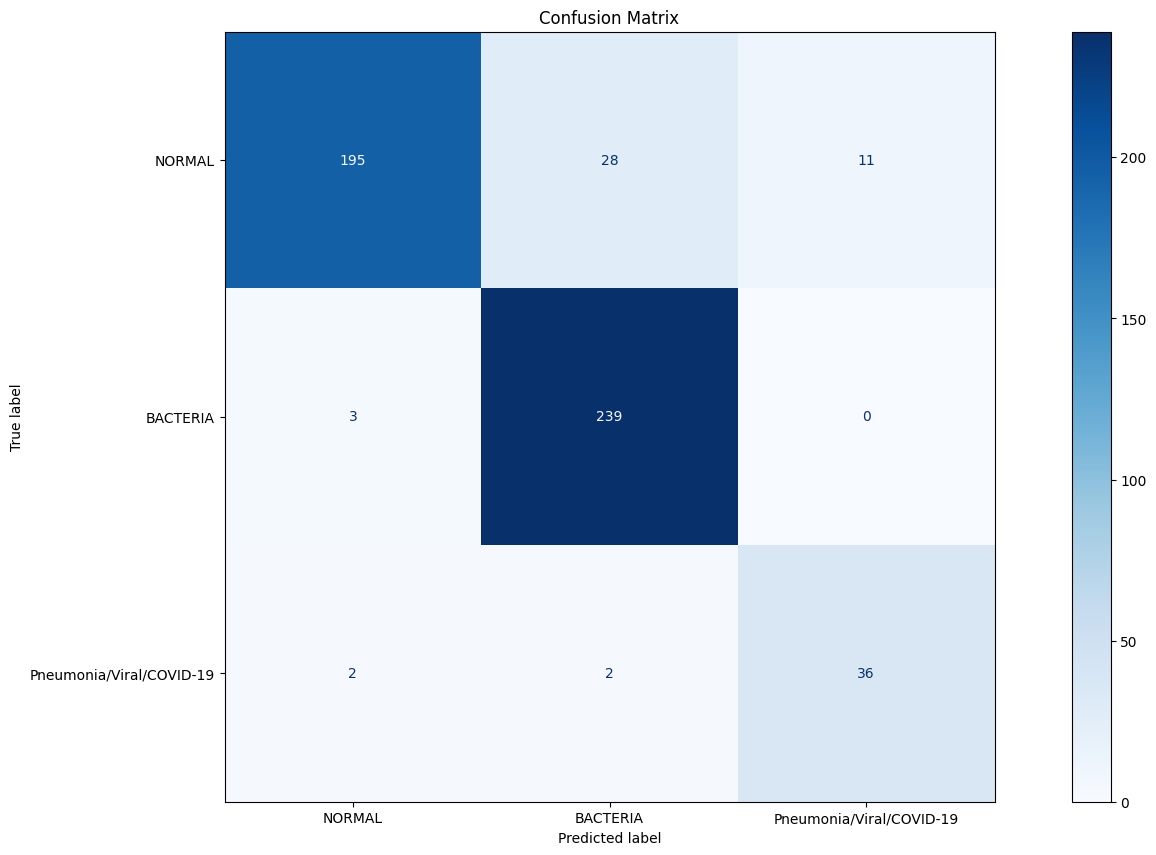

Precision (macro): 0.8765
Recall (macro):    0.9070
F1 Score (macro):  0.8872


(0.8764777610799124, 0.9069788797061524, 0.8872081540190702)

In [ ]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model_oversampling = Classificaion_CNN(num_classes=3)

# Train the model
train_losses_oversampled, train_accuracies_oversampled, val_losses_oversampled, val_accuracies_oversampled = train_model(model_oversampling, train_oversampled_loader, val_loader, num_epochs=8, device=device, criterion=nn.CrossEntropyLoss())

# Evaluate the model
evaluate_model(model_oversampling, test_loader, device, class_names=list(finding_to_label.keys()))

### e. Train the model using class weights

Class weights: tensor([0.9991, 0.5310, 8.6240])
Epoch [1/8]  Train Loss: 0.4573  Acc: 79.38%  | Val Loss: 0.2804  Acc: 94.31%
Epoch [2/8]  Train Loss: 0.2188  Acc: 90.75%  | Val Loss: 0.2011  Acc: 94.68%
Epoch [3/8]  Train Loss: 0.1684  Acc: 93.44%  | Val Loss: 0.1768  Acc: 95.43%
Epoch [4/8]  Train Loss: 0.1436  Acc: 93.69%  | Val Loss: 0.1717  Acc: 96.04%
Epoch [5/8]  Train Loss: 0.1080  Acc: 95.58%  | Val Loss: 0.1926  Acc: 95.06%
Epoch [6/8]  Train Loss: 0.0994  Acc: 95.83%  | Val Loss: 0.1582  Acc: 96.29%
Epoch [7/8]  Train Loss: 0.0814  Acc: 96.69%  | Val Loss: 0.2135  Acc: 96.66%
Epoch [8/8]  Train Loss: 0.0813  Acc: 96.66%  | Val Loss: 0.2294  Acc: 95.18%


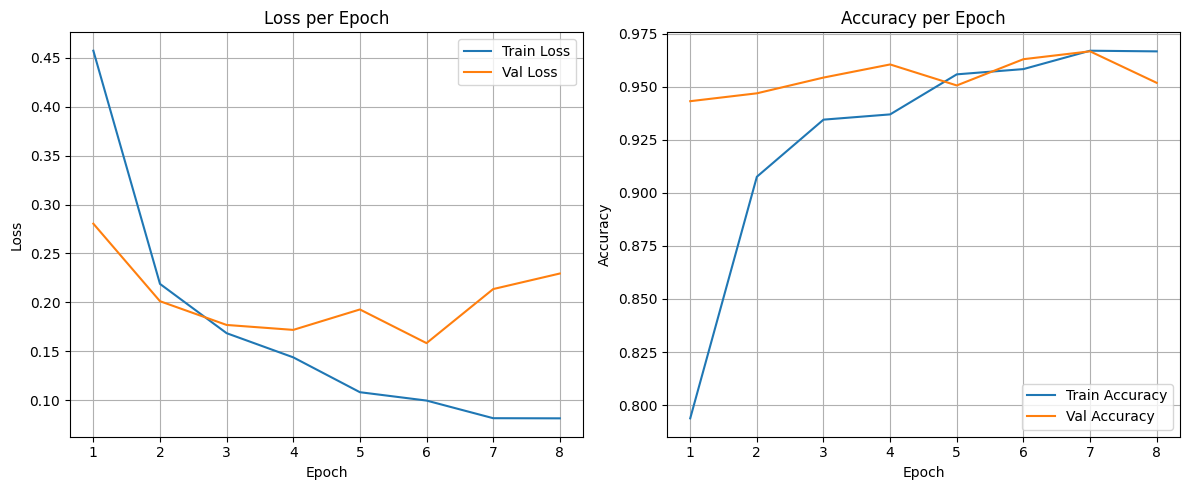

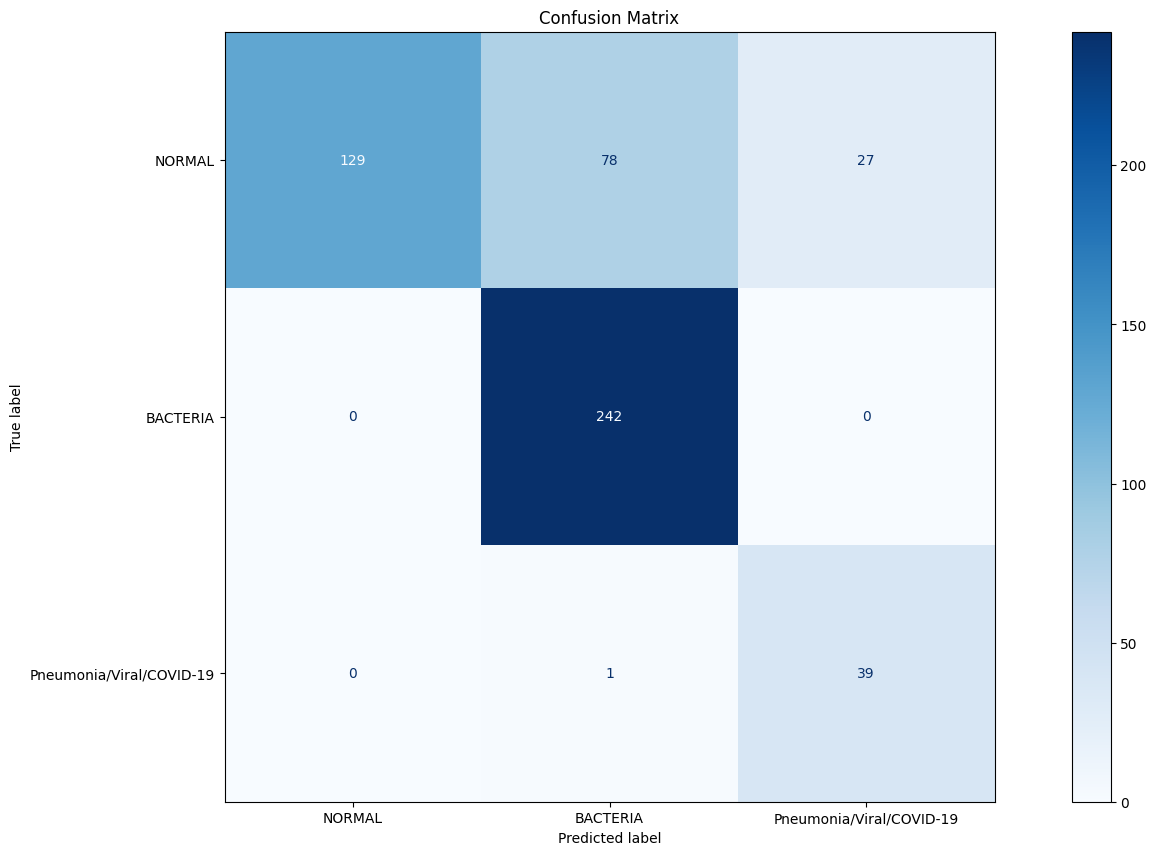

Precision (macro): 0.7816
Recall (macro):    0.8421
F1 Score (macro):  0.7688


(0.7816010573019918, 0.8420940170940171, 0.7687577141494986)

In [ ]:
# Calculate class weights
class_counts = train_df['label'].value_counts()
total_samples = len(train_df)
class_weights = total_samples / (len(finding_to_label) * class_counts)

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class weights tensor
class_weights = torch.tensor(class_weights.sort_index().values, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

# Create the model
model_class_weights = Classificaion_CNN(num_classes=3)

# Train the model
train_losses_weighted, train_accuracies_weighted, val_losses_weighted, val_accuracies_weighted = train_model(model_class_weights, train_loader, val_loader, num_epochs=8, device=device, criterion = nn.CrossEntropyLoss(weight=class_weights)) # Use class weights in the loss function

# Evaluate the model
evaluate_model(model_class_weights, test_loader, device, class_names=list(finding_to_label.keys()))

# 3. Transfer Learning


### a. Load the ResNet18 pretrained model

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torchsummary

In [ ]:
from torchvision.models import resnet18
from torchsummary import summary

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
resnet_model = resnet18(pretrained=True).to(device)

# Layer-wise breakdown of the model
summary(resnet_model, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### b. Freeze all layers except the last three

In [ ]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
resnet_model = resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel input
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Freeze all layers except the last three
for name, param in resnet_model.named_parameters():
    if name.startswith('layer4') or name.startswith('fc') or name.startswith('avgpool'):
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace the final classification layers (fc) with a new head
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3)  # 3 output classes
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### c. Train the model

Epoch [1/8]  Train Loss: 0.3974  Acc: 84.85%  | Val Loss: 0.2496  Acc: 91.10%
Epoch [2/8]  Train Loss: 0.2425  Acc: 91.71%  | Val Loss: 0.3584  Acc: 90.85%
Epoch [3/8]  Train Loss: 0.1804  Acc: 93.94%  | Val Loss: 0.2161  Acc: 92.09%
Epoch [4/8]  Train Loss: 0.1489  Acc: 94.77%  | Val Loss: 0.1920  Acc: 91.97%
Epoch [5/8]  Train Loss: 0.1496  Acc: 94.96%  | Val Loss: 0.2178  Acc: 92.58%
Epoch [6/8]  Train Loss: 0.1348  Acc: 96.51%  | Val Loss: 0.2502  Acc: 91.47%
Epoch [7/8]  Train Loss: 0.1150  Acc: 96.85%  | Val Loss: 0.1971  Acc: 93.33%
Early stopping triggered at epoch 7


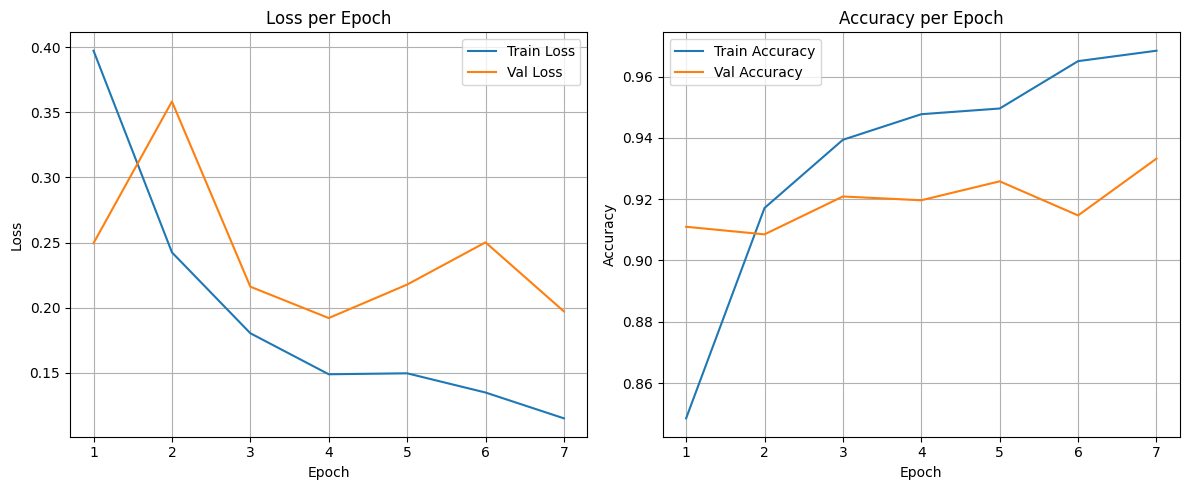

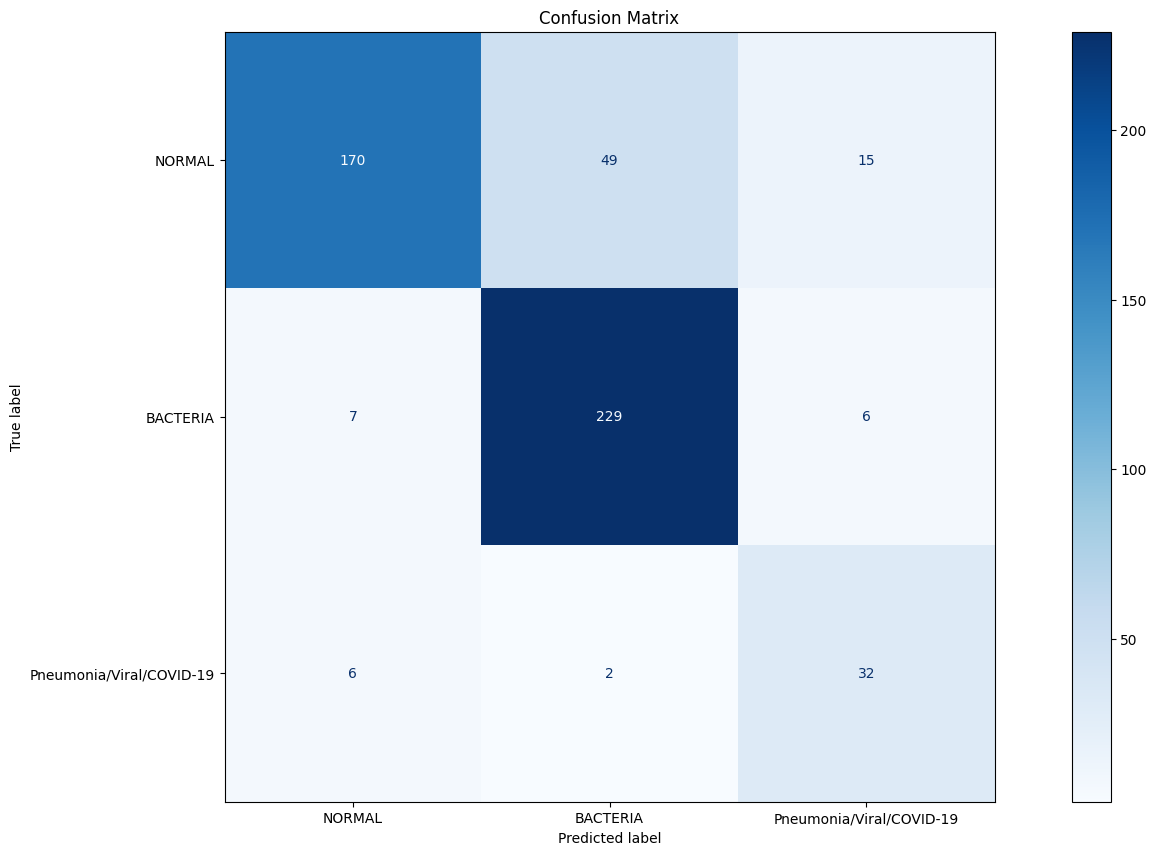

Precision (macro): 0.7835
Recall (macro):    0.8243
F1 Score (macro):  0.7936


(0.783530825465561, 0.8242589060770878, 0.7936381336162069)

In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    resnet_model, train_loader, val_loader, num_epochs=8, device=device, criterion=nn.CrossEntropyLoss())


# Evaluate the model
evaluate_model(resnet_model, test_loader, device, class_names=list(finding_to_label.keys()))

# 4. t-SNE

In [ ]:
# Import the TSNE class from the sklearn.manifold library
from sklearn.manifold import TSNE

Apply 2D t-SNE on the feature representations obtained from the ResNet18 model and the best CNN model from Section 2 (oversampling model)

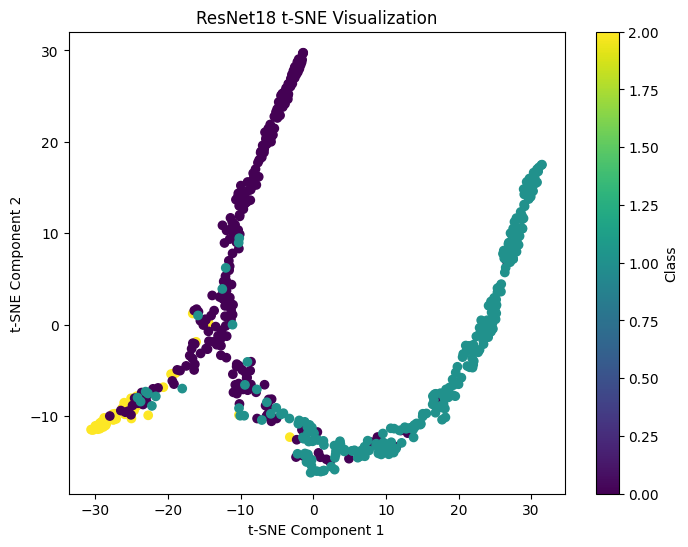

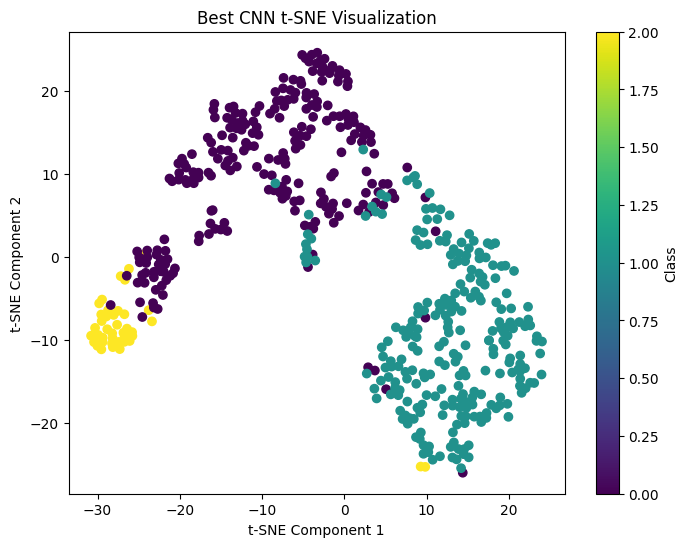

In [ ]:
# Feature representation function
def get_feature_representations(model, dataloader, device):
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Get feature representations for ResNet18
resnet_features, resnet_labels = get_feature_representations(resnet_model, test_loader, device)

# Get feature representations for best CNN model
cnn_features, cnn_labels = get_feature_representations(model_oversampling, test_loader, device)

# t-SNE plot function
def apply_tsne_and_plot(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)  # Initialize t-SNE
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Apply t-SNE and plot for ResNet18
apply_tsne_and_plot(resnet_features, resnet_labels, 'ResNet18 t-SNE Visualization')

# Apply t-SNE and plot for the best CNN model
apply_tsne_and_plot(cnn_features, cnn_labels, 'Best CNN t-SNE Visualization')


The t-SNE visualization shows that the CNN model trained with oversampling produces more compact and well-separated feature clusters compared to ResNet18. While ResNet18 exhibits partial overlap between NORMAL and BACTERIA classes, the CNN demonstrates clearer class boundaries, leading to improved classification performance, especially for COVID-19. This improvement is because ResNet18, pretrained on natural RGB images, was only partially fine-tuned for grayscale medical data, while the CNN was trained from scratch on the oversampled chest X-ray dataset. As a result, the CNN learned task-specific, more discriminative features, which are reflected both in the t-SNE visualization and in its superior classification results.